# Handwritten Digit Recognition

This tutorial guides you through a classic computer vision application: identify hand written digits with a multi-layer perceptron neural network.

## Tools

* Keras (for the neural network creation)
* Matplot (to graph training history)
* Numpy (for data types and tensor operations)
* Scikitlearn (for data normalization)


## Step 1: Load the MNIST dataset
We first load the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a classic in the machine-learning community, which has been around almost as long as the field itself and has been intensively studied. It’s a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. Each image in this dataset has been resized into 28x28 with grayscale values between 0 and 254.

The following code load the images and the according labels. The variables x_train and y_train form the training set, the data that the model will learn from. The model will then be tested on the test set (x_test and y_test variables).

In [2]:
import keras
from keras.datasets import mnist
import numpy
(x_train, y_train), (x_test, y_test) = mnist.load_data() # The dataset will be downloaded the first time.

To see the dataset's content we plot the first 10 images and print their labels from training set. The next code iterate over the first 10 samples of the train set and use library matplotlib to show the images graphically and print the respective labels.

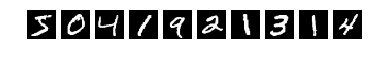

label: [5 0 4 1 9 2 1 3 1 4]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (y_train[0:10],))

The next code show the shape (dimensions) of the train and test sets.

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


We see that there are 60,000 and 10,000 samples for the train and test sets respectively with an array of 28 by 28 pixels each one.

## Step 2: Preprocess input data for neural network

The MNIST training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer model <b>we must reduce the datasets down into a two dimensional array</b> by applying reshaping. Apply tensor reshaping means rearrangement of its dimensions to match a target shape (in this case the input shape needed by the following neural network's input <b>densely connected layer</b> of the step 4 that is a two dimensional array).

The following code transforms the train and test sets with shape of (n_samples, image_width, image_height) to (n_samples, image_width * image_height).


In [5]:
x_train = x_train.reshape(x_train.shape[0], 784)# image_width * image_height = 784
x_test = x_test.reshape(x_test.shape[0], 784) # 28 * 28 = 784

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway. The next code cast the datatype of each value within the train and test sets.

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

When using neural network models is a good idea to perform normalization of the values to the range 0 and 1. The next code use a function from Scikitlearn to normalize (values between 0 and 1) each value within the train and test sets.

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

## Step 3: Preprocess class labels for neural network

First of all we show class label's shape of train and test sets. 

In [8]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


The number of values per sample isn't clear because there is a blank value. Let's show the first 10 training's label values.

In [9]:
print y_train[:10]

[5 0 4 1 9 2 1 3 1 4]


The problem is that there are 1-dimensional class arrays and the model spects a class matrix. Then we convert the 1-dimensional class arrays into a 10-dimensional class matrix. We can easily do this using the built-in to_categorical() helper function in Keras (this step is also called one hot encoding). <br><br>
The next code use the to_categorical() function to convert the 1-dimensional class arrays into a 10-dimensional class matrix of the train and test sets and show again it's shapes.

In [10]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


Now we have the needed 10-dimensional matrix per label.

Let's show the first 10 labels again.

In [11]:
print y_train[:10]

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now there is a matrix of float numbers instead of only one integer number, indicating the probability of each class in a normalized way (the average of each matrix is one).

## Step 4: Define model's arquitecture and layers

In this tutorial we will use an multi-layer perceptron that is perhaps one of the most traditional type of deep learning architecture, and that's when every neuron of a previous layer, is connected to every neuron of the next layer. It looks like this:


![title](nb1-2.png)

In Keras to define a model there are two ways:
* By using the [Sequential Model](https://keras.io/models/sequential) that is a linear stack of layers.
* Or by using [the functional API](https://keras.io/models/model) that is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.
<br><br>

Let's start by declaring a sequential model, which is the most common way by far.

In [12]:
from keras.models import Sequential

model = Sequential()

Now declare the input layer, as a 784 way [densely connected](https://keras.io/layers/core/#dense) (also called fully connected). A dense layer is just a regular layer of neurons in a neural network. Each neuron recieves input from all the neurons in the previous layer (in this case the input data), thus densely connected. <br>

In [13]:
from keras.layers import Dense

model.add(Dense(28*28, input_dim=28*28, activation='relu', kernel_initializer='normal'))

The first parameter corresponds to the dimensionality of the output space (the number of outgoing units or neurons).<br>
The input shape (second parameter) should be the same of the training input (in this case the number of features).<br>
The [activation supported by keras](https://keras.io/activations/) is a function (either linear or non-linear) that limits the output signal to a finite value.<br>
The [kernel_initializer supported by Keras](https://keras.io/initializers/) specifies how the layer's weights are initially randomized. 
<br><br>
Dense layer implements the operation: output = <b>activation(dot(input, kernel) + bias)</b> where:<br>
<b>activation</b> is the activation function.<br>
<b>dot</b> means the multiplication of input and kernel arrays.<br>
<b>input</b> is the training data.<br>
<b>kernel</b> is an array containing the weight of each neuron which initial values was generated randomly.<br>
<b>bias</b> is a vector created by the layer which initial values was generated randomly.<br>
<br>
The [activations supported by keras](https://keras.io/activations/) are the following:
![title](nb1-3.png)
<br><br>

At this point we can add more layers to our model like we're  building legos.

The next code adds the output layer to the model with 10 neurons (corresponding to the 10 classes of digits):

In [14]:
model.add(Dense(10, kernel_initializer='normal', activation='softmax'))

The softmax activation function is used on the output layer to turn the outputs into probability-like (values between 0 and 1).<br>
Note that <b>Keras automatically handles the connections between layers</b>.
<br><br>

The resulting model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784) and an output layer with 10 neurons (number of classes).

![title](nb1-1.jpg)

## Step 5: Compile model

At this point only we need to define the loss function and the optimizer, and then the model will be ready to train.

Compile a model means the declaration of the loss function and the optimizer (SGD, Adam, etc).

In [15]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Keras has a variety of [loss functions](https://keras.io/objectives/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from.

## Step 6: Fit model on training data

To fit the model, all we have to do is to declare the batch size and number of epochs to train for, then pass in our training data.

In [16]:
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=30, 
                    verbose=2,
                    validation_split=0.2)


Train on 48000 samples, validate on 12000 samples
Epoch 1/30
 - 38s - loss: 0.2129 - acc: 0.9363 - val_loss: 0.1271 - val_acc: 0.9614
Epoch 2/30
 - 33s - loss: 0.0813 - acc: 0.9749 - val_loss: 0.0972 - val_acc: 0.9692
Epoch 3/30
 - 33s - loss: 0.0525 - acc: 0.9837 - val_loss: 0.0898 - val_acc: 0.9738
Epoch 4/30
 - 34s - loss: 0.0368 - acc: 0.9882 - val_loss: 0.0952 - val_acc: 0.9742
Epoch 5/30
 - 37s - loss: 0.0267 - acc: 0.9914 - val_loss: 0.0814 - val_acc: 0.9777
Epoch 6/30
 - 40s - loss: 0.0188 - acc: 0.9939 - val_loss: 0.0845 - val_acc: 0.9778
Epoch 7/30
 - 37s - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0957 - val_acc: 0.9763
Epoch 8/30
 - 38s - loss: 0.0140 - acc: 0.9958 - val_loss: 0.1031 - val_acc: 0.9751
Epoch 9/30
 - 36s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0851 - val_acc: 0.9802
Epoch 10/30
 - 36s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0888 - val_acc: 0.9795
Epoch 11/30
 - 36s - loss: 0.0105 - acc: 0.9968 - val_loss: 0.0947 - val_acc: 0.9788
Epoch 12/30
 - 35s - los

## Step 7: Evaluate model on test data

We can evaluate our model on the test data.

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


('Test loss:', 0.12782511346242906)
('Test accuracy:', 0.9812)


## Step 8: Graph training history

We can graph the training history to visualize the neural network performance over each iteration.

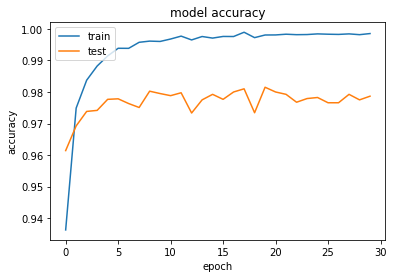

In [18]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally we can graph the loss history over each iteration .

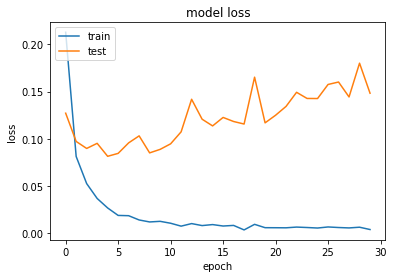

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()